# Load, inspect and prepare data

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf 
import matplotlib.pyplot as plt
import cv2 as cv

In [3]:
# Define train and test directories
dataset_dir = "../input/100-bird-species"

train_dir = dataset_dir + "/" + "train"
test_dir = dataset_dir + "/" + "test"
valid_dir = dataset_dir + "/" + "valid"

train_dir, test_dir, valid_dir

('../input/100-bird-species/train',
 '../input/100-bird-species/test',
 '../input/100-bird-species/valid')

In [4]:
# load data using tensorflow ImageDataGenerator class
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator instance
data_generator = ImageDataGenerator(rescale = 1/255.0)

IMG_SIZE = (224, 224) # all images in Bird Species dataset have size of 224x224

# Load train and test images from directories
train_dataset = data_generator.flow_from_directory(train_dir,
                                                  target_size = IMG_SIZE
                                                  )
test_dataset = data_generator.flow_from_directory(test_dir,
                                                  target_size = IMG_SIZE
                                                  )
valid_dataset = data_generator.flow_from_directory(valid_dir,
                                                  target_size = IMG_SIZE
                                                  )

Found 53929 images belonging to 370 classes.
Found 1850 images belonging to 370 classes.
Found 1850 images belonging to 370 classes.


In [5]:
# Get class names
class_names = train_dataset.class_indices
class_names = list(class_names.keys())

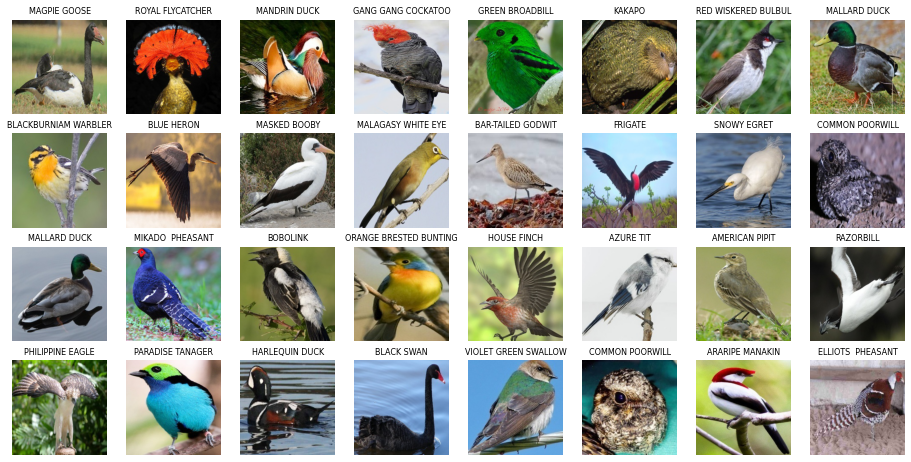

In [7]:
# View some samples from dataset
# get single batch from dataset
data_one_batch = train_dataset.next()  
images_one_batch = data_one_batch[0]      
# labels are one-hot encoded, so we take argmax to get numerical representation
classes_one_batch = tf.argmax(data_one_batch[1], axis = 1)  


plt.figure(figsize = (16,8))
for n, image in enumerate(images_one_batch):
  plt.subplot(4, 8, n+1)
  plt.imshow(image)
  plt.title(class_names[classes_one_batch[n]], fontdict = {'fontsize' : 8})
  plt.axis("off")

# Transfer learning using EffecientNetB0

Creating and training model using EfficientNetB0 baseline from Tensorflow Hub


In [8]:
import tensorflow_hub as hub

baseline = hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
           trainable=False) # we're not training baseline model's layers to prevent overfitting

In [10]:
# set random seed
tf.random.set_seed(42)

# create the model using sequential API
model = tf.keras.Sequential([
      baseline,
      tf.keras.layers.Dense(len(class_names), activation = "softmax")
])

# compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.categorical_crossentropy,
              metrics = ["accuracy"])

# fit the model
history_0 = model.fit(train_dataset,
                      epochs = 6,
                      validation_data = valid_dataset)

Epoch 1/6
1686/1686 [==============================] - 293s 173ms/step - loss: 1.3787 - accuracy: 0.7445 - val_loss: 0.3701 - val_accuracy: 0.9276
Epoch 2/6
1686/1686 [==============================] - 139s 82ms/step - loss: 0.4105 - accuracy: 0.9127 - val_loss: 0.2412 - val_accuracy: 0.9438
Epoch 3/6
1686/1686 [==============================] - 140s 83ms/step - loss: 0.2539 - accuracy: 0.9468 - val_loss: 0.1931 - val_accuracy: 0.9568
Epoch 4/6
1686/1686 [==============================] - 142s 84ms/step - loss: 0.1709 - accuracy: 0.9664 - val_loss: 0.1770 - val_accuracy: 0.9578
Epoch 5/6
1686/1686 [==============================] - 132s 78ms/step - loss: 0.1192 - accuracy: 0.9789 - val_loss: 0.1705 - val_accuracy: 0.9600
Epoch 6/6
1686/1686 [==============================] - 133s 79ms/step - loss: 0.0862 - accuracy: 0.9856 - val_loss: 0.1533 - val_accuracy: 0.9605


Let's try fine-tuning to improve our model. for this, we will make the baseline model's layers trainable

In [11]:
model.layers[0].trainable = True

In [12]:
# recompile the model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # use lower learning rate when fine-tuning
              loss = tf.keras.losses.categorical_crossentropy,
              metrics = ["accuracy"])


In [13]:
# fit the model
history_1 = model.fit(train_dataset,
                      epochs = 8,
                      validation_data = valid_dataset,
                      initial_epoch = 6)

Epoch 7/8
1686/1686 [==============================] - 207s 117ms/step - loss: 0.2361 - accuracy: 0.9391 - val_loss: 0.0743 - val_accuracy: 0.9795
Epoch 8/8
1686/1686 [==============================] - 198s 117ms/step - loss: 0.0856 - accuracy: 0.9786 - val_loss: 0.0580 - val_accuracy: 0.9816


In [15]:
# evaluate model on test data
model.evaluate(test_dataset)

58/58 [==============================] - 10s 174ms/step - loss: 0.0495 - accuracy: 0.9876


[0.04945868253707886, 0.9875675439834595]

In [17]:
# save model
model.save("./370_bird_species_EFFNetB0.h5")

# Analyze model predictions on test data

In [18]:
# get model predictions and true labels
import numpy as np

images = []
true_labels = []
predictions = []

for n in range(len(test_dataset)):
  image_batch, label_batch = test_dataset.next()
  images.append(image_batch)
  true_labels.append(tf.argmax(label_batch, axis = 1))
  predictions.append(tf.argmax(model.predict(image_batch), axis = 1))

images = np.concatenate(images)
true_labels = np.concatenate(true_labels)
predictions = np.concatenate(predictions)

In [19]:
# get wrong predictions
mask = true_labels != predictions
images = images[mask]
true_labels = true_labels[mask]
predictions = predictions[mask]

len(images), len(true_labels), len(predictions)

(23, 23, 23)

23 predictions were wrong, let's visualize them

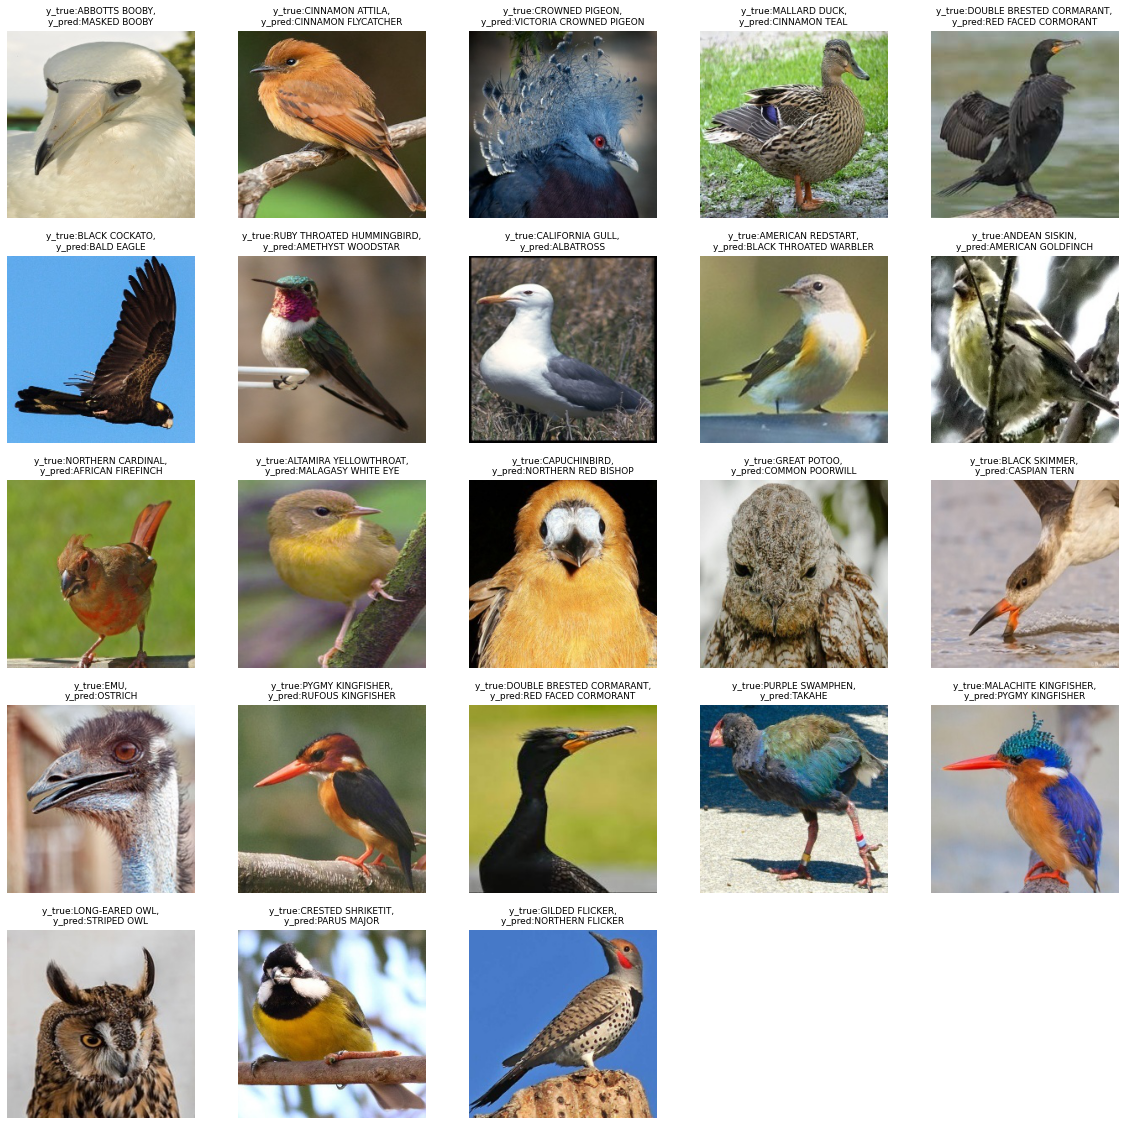

In [20]:
# visualize wrong predictions

plt.figure(figsize =  (20, 20))
for n, image in enumerate(images):
  plt.subplot(5, 5, n+1)
  plt.imshow(image)
  plt.title(f"y_true:{class_names[true_labels[n]]},\ny_pred:{class_names[predictions[n]]}", fontdict = {"fontsize" : 9})
  plt.axis('off')

# Integrating with object detection model to detect different bird species in an image

We have built a classifier that can determine what species does the bird belong to based on it's image. 

It will also be interesting to integrate this model to the existing object detector that can find birds in images. The resulting system will not only detect birds, but will also identify their species.

## Step 1: Bird detector

For this we will use pretrained object detection model EfficientDet-D1 from Tensorflow Hub.

This model was trained on COCO 2017 dataset where class number 16 is bird.


In [21]:
import tensorflow_hub as hub

detector = hub.load("https://tfhub.dev/tensorflow/efficientdet/d1/1")

Let's create a function that will use this model to extract birds from an image and return their coordinates.

In [22]:
def extract_bird_roi(model, image, threshold = 0.5):
  # get image dimensions
  width, height = image.shape[0], image.shape[1]

  # perform object detection
  detector_output = model(np.expand_dims(image, axis = 0))

  # bird class is 16th in the coco dataset
  bird_mask = detector_output["detection_classes"] == 16
  # apply threshold
  bird_mask = (detector_output["detection_scores"] > threshold) & bird_mask
  bird_boxes = detector_output["detection_boxes"][bird_mask]


  bird_images = []
  # this will be a list of tuples with pair: 
  # ROI (Region Of Interest), Box coordinates
  
  # extract ROI and coordinates for each detected bird
  for box in bird_boxes:
    min_corner = (int(box[1] * height), int(box[0] * width))
    max_corner = (int(box[3] * height), int(box[2] * width))
    bird_images.append((image[min_corner[1] : max_corner[1], min_corner[0] : max_corner[0]],  
                        (min_corner, max_corner)))
  
  return bird_images

To test this function we will use the following image of ostriches.
Source: https://www.livescience.com/biggest-birds-on-earth
(Image credit: Getty Images)

(-0.5, 1023.5, 575.5, -0.5)

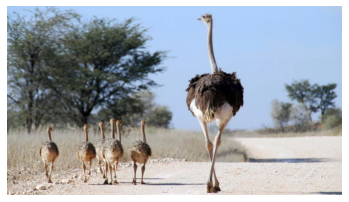

In [23]:
ostriches_image = plt.imread("../input/d/ratichkhetia/bird-photos/ostriches.jpg")
plt.imshow(ostriches_image)
plt.axis("off")

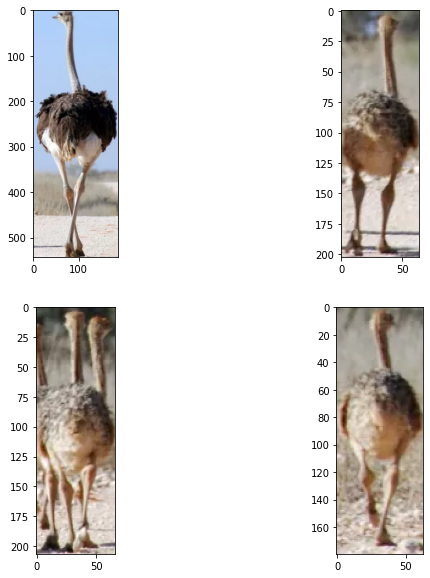

In [25]:
rois = extract_bird_roi(detector, ostriches_image, threshold = 0.5)

plt.figure(figsize = (10, 10))

plt.subplot(2, 2, 1)
plt.imshow(rois[0][0])
plt.subplot(2, 2, 2)
plt.imshow(rois[1][0])
plt.subplot(2, 2, 3)
plt.imshow(rois[2][0])
plt.subplot(2, 2, 4)
plt.imshow(rois[3][0])

Let's test for another image.

(-0.5, 799.5, 1150.5, -0.5)

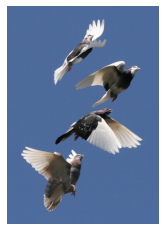

In [26]:
pigeons_image = plt.imread("../input/d/ratichkhetia/bird-photos/Domestic_Pigeon_Flock.jpg")
plt.imshow(pigeons_image)
plt.axis("off")

Source: https://en.wikipedia.org/wiki/Bird_flight#/media/File:Domestic_Pigeon_Flock.jpg
Author: Toby Hudson|

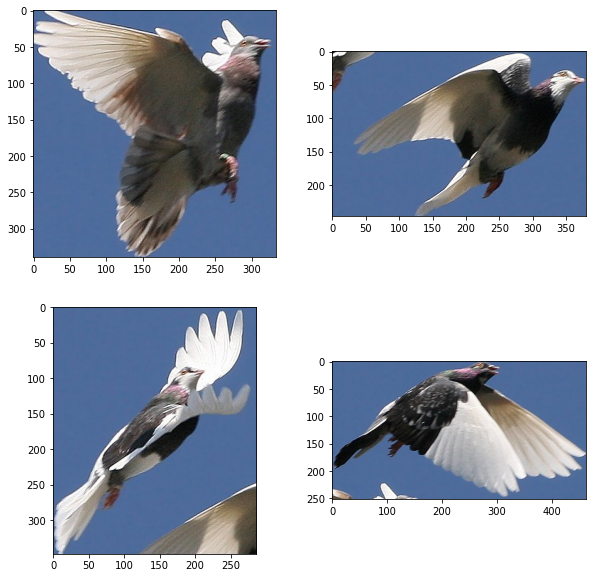

In [27]:
rois = extract_bird_roi(detector, pigeons_image, threshold = 0.5)

plt.figure(figsize = (10, 10))

plt.subplot(2, 2, 1)
plt.imshow(rois[0][0])
plt.subplot(2, 2, 2)
plt.imshow(rois[1][0])
plt.subplot(2, 2, 3)
plt.imshow(rois[2][0])
plt.subplot(2, 2, 4)
plt.imshow(rois[3][0])

## Step 2: Integrate Species Classifier with the Bird Detector

Now we will create a function that takes regions of interest obtained from the previous model and uses bird classifier to predict species of birds present in those regions.

We will also draw bounding boxes on an image and print corresponting bird species in them.

In [64]:
rois = extract_bird_roi(detector, ostriches_image, threshold = 0.5)

def identify_species(model, rois):
    
    predictions = [] # list of bird species identified
    
    for roi in rois:
        roi_resized = tf.image.resize(roi[0] / 255.0, (224, 224))
        prediction = tf.argmax(model.predict(tf.expand_dims(roi_resized, axis = 0)), axis = 1)
        predictions.append((class_names[int(prediction)]))

    return predictions

In [65]:
identify_species(model = model, rois = rois)

['OSTRICH', 'OSTRICH', 'BLACK FRANCOLIN', 'ANDEAN GOOSE', 'BLACK FRANCOLIN']

Some predictions are incorrect because extracted regions of interest have very low resolution

Let's build a function to draw bounding boxes with text

In [102]:
def draw_bounding_boxes_with_text(image, rois, predictions):
    image_copy = image.copy()
    
    for n, roi in enumerate(rois):
        cv.rectangle(image_copy, roi[1][0], roi[1][1], (0, 255, 0))
        cv.putText(image_copy, predictions[n], roi[1][0], 
                   cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    
    return image_copy

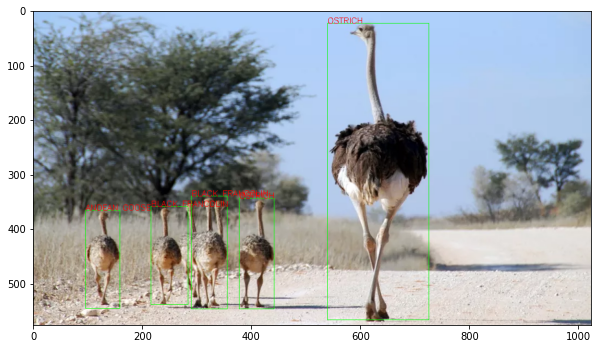

In [104]:
plt.figure(figsize = (10, 10))
plt.imshow(draw_bounding_boxes_with_text(image = ostriches_image, rois = rois, 
                                         predictions = identify_species(model = model, rois = rois)))

Now we'll build a function that combines object detection and species identification

In [107]:
def detect_bird_species(image, bird_detector = detector, species_classifier = model):
    # detect birds in the image
    rois = extract_bird_roi(bird_detector, image, threshold = 0.5)
    
    # identify bird species
    species = identify_species(species_classifier, rois)
    
    # draw bounding boxes and text
    output_image = draw_bounding_boxes_with_text(image, rois, species)
    
    return output_image

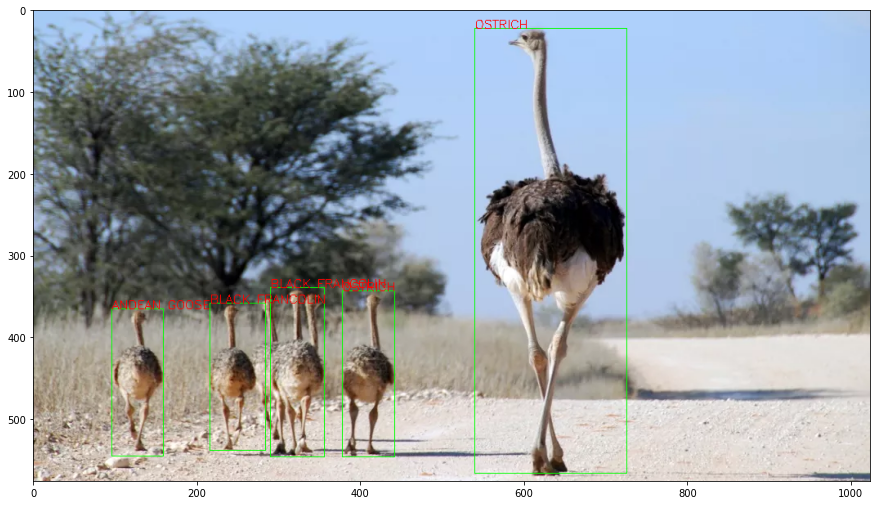

In [111]:
plt.figure(figsize = (15, 15))
plt.imshow(detect_bird_species(ostriches_image))

Let's try some other images

In [112]:
blue_bird = plt.imread("../input/d/ratichkhetia/bird-photos/blue_bird.jpg")

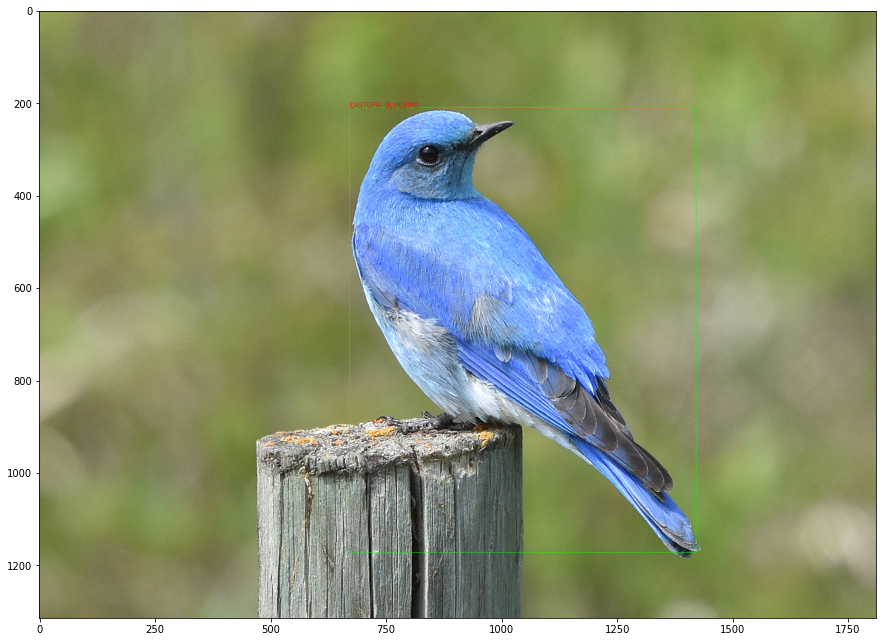

In [113]:
plt.figure(figsize = (15, 15))
plt.imshow(detect_bird_species(blue_bird))

Image source: https://www.birdwatchingdaily.com/news/birdwatching/birds-increase-human-happiness-study-finds/
A Mountain Bluebird in Alberta. Photo by David Mundy

In [125]:
three_birds = plt.imread("../input/d/ratichkhetia/bird-photos/three_birds.jpg")

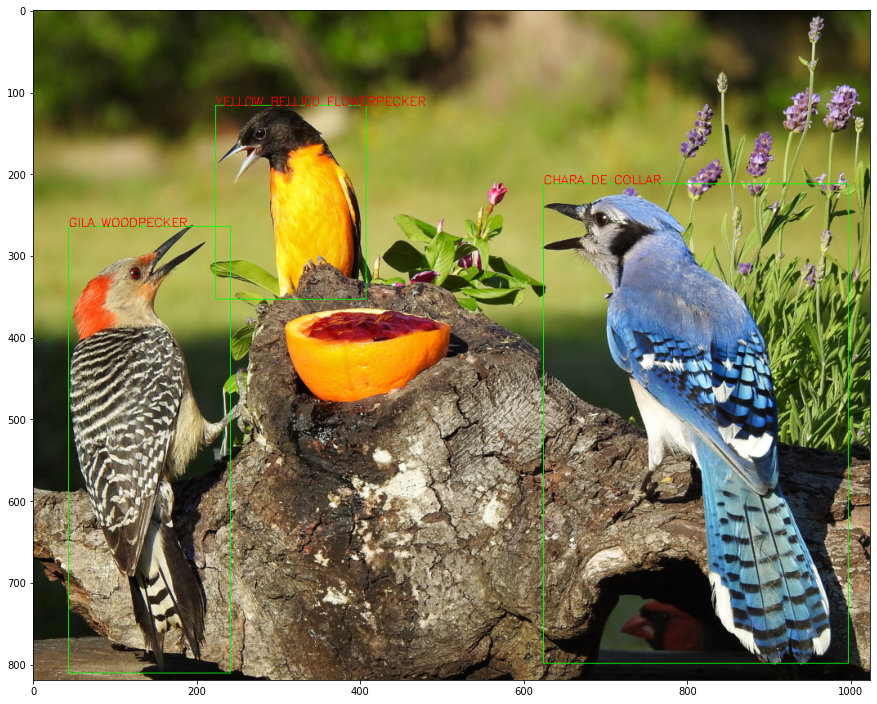

In [127]:
plt.figure(figsize = (15, 15))
plt.imshow(detect_bird_species(three_birds))

Image source: https://feederwatch.org/blog/2020-2021-birdspotter-grand-prize-winners/

| Jelly Squabble! by Pam Garcia |